In [1]:
# hide
# all_slow

# Explore Poverty Mapping Machine Learning Models
> Building Poverty Mapping Machine Learning (ML)  Models with Geowrangler 

## Introduction

The aim of this notebook is to demonstrate how GeoWrangler can be used to make the process of generating ML-ready or analytics-ready datasets from raw geospatial data easier.

Concretely, this shows a sample workflow for a wealth estimation model trained on a dataset constructed using:
* Ground Truth - [DHS](https://dhsprogram.com/) household clusters + wealth indices
* Features - Derived from Night Time Lights, OSM POIs, and Ookla internet speeds.

> Note: the goal here is to showcase GeoWrangler's functions for geospatial data wrangling and feature engineering. Hence, this notebook keeps the ML modelling portions as simple as possible.*

## Set-up

Install and import some libraries.

In [2]:
# hide
# no_test
![ -e /content ] && pip install geopandas==0.10.2
![ -e /content ] && pip install folium==0.12.1.post1
![ -e /content ] && pip install mapclassify==2.4.3
![ -e /content ] && pip install git+https://github.com/thinkingmachines/geowrangler.git
![ -e /content ] && pip uninstall pygeos shapely -y
![ -e /content ] && pip install pygeos==0.12.0 shapely==1.8.5  --no-binary pygeos --no-binary shapely

In [3]:
from pathlib import Path

import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from shapely import wkt
from sklearn.ensemble import RandomForestRegressor

import geowrangler.area_zonal_stats as azs
import geowrangler.distance_zonal_stats as dzs
import geowrangler.raster_zonal_stats as rzs
import geowrangler.vector_zonal_stats as vzs
from geowrangler import grids
from geowrangler.datasets import geofabrik, ookla

## Pre-requisite: Manual Data Download

In [4]:
# hide
# no_test
!mkdir -p ../data
![ -e /content ] && ln -s ../data .

In [5]:
# no_test
# download data if not yet available
![ ! -e ../data/phl_adm0.geojson ] && curl -s -o ../data/phl_adm0.geojson https://raw.githubusercontent.com/thinkingmachines/geowrangler/master/data/phl_adm0.geojson
![ ! -e ../data/phl_dhs_cluster_level.csv ] && curl -s -o ../data/phl_dhs_cluster_level.csv https://raw.githubusercontent.com/thinkingmachines/geowrangler/master/data/phl_dhs_cluster_level.csv
![ ! -e ../data/phl_ntl.tif ] && curl -s -o ../data/phl_ntl.tif https://raw.githubusercontent.com/thinkingmachines/geowrangler/master/data/phl_ntl.tif

In [6]:
DATA_DIR = Path("../data/")
# Auto-creates the folder if it does not exist
DATA_DIR.mkdir(parents=True, exist_ok=True)

Your data directory should look something like this.

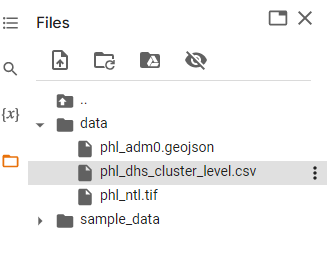

## Data Preparation

### DHS Ground Truth

The ground truth used in this demo notebook is from a DHS 2017 on-the-ground household survey conducted in the Philippines regarding the households' socio-demographic information.

The file we provide is already a pre-processed version of the data that is aggregated on a household-cluster level, meaning the information cannot be tied back to any individual household. Specifically, we only provide a list of household clusters with their corresponding (jittered) GPS coordinate and  DHS-computed wealth index.

Due to the sensitive nature of the data and the DHS program terms of use, we cannot provide the raw data. You can, however, request for access to raw data yourself on the [DHS website](https://dhsprogram.com/data/new-user-registration.cfm). In that case, you can use GeoWrangler's [DHS processing utils](https://geowrangler.thinkingmachin.es/tutorial.dhs.html) help perform the said pre-processing.

Our first step is to create a GeoDataFrame from the data.

In [7]:
# Load ground truth data as a DataFrame first
GROUND_TRUTH_CSV = DATA_DIR / "phl_dhs_cluster_level.csv"
df = pd.read_csv(GROUND_TRUTH_CSV)

# Some of the coordinates in the data are invalid. This filters them out.
df = df[(df.longitude > 0) & (df.latitude > 0)]

# Create a GeoDataFrame from the longitude, latitude columns.
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="epsg:4326"
)

print(f"There are {len(gdf):,} clusters.")
gdf.head()

There are 1,213 clusters.


,DHSCLUST,Wealth Index,DHSID,longitude,latitude,geometry
0,1,-31881.60870,PH201700000001,122.109807,6.674652,POINT (122.10981 6.67465)
1,2,-2855.37500,PH201700000002,122.132027,6.662256,POINT (122.13203 6.66226)
2,3,-57647.04762,PH201700000003,122.179496,6.621822,POINT (122.17950 6.62182)
3,4,-54952.66667,PH201700000004,122.137965,6.485298,POINT (122.13796 6.48530)
5,6,-80701.69565,PH201700000006,121.916094,6.629457,POINT (121.91609 6.62946)


Next, we want to create a buffer around each cluster centroid that represents the area's neighborhood. This is so we can engineer some features and characterize these neighborhoods using open data.

*This is a design decision, but for this demo, we'll create a circlular area with a 2km radius following the random displacement introduced by DHS to preserve household privacy.*

In [8]:
# Make sure to convert to PH crs first for the buffer in meters, and then back to WGS84
gdf = gdf.to_crs("epsg:3123")
gdf.geometry = gdf.geometry.buffer(2000)
gdf = gdf.to_crs("epsg:4326")

gdf.head(5)

,DHSCLUST,Wealth Index,DHSID,longitude,latitude,geometry
0,1,-31881.60870,PH201700000001,122.109807,6.674652,"POLYGON ((122.12789 6.67461, 122.12780 6.67284..."
1,2,-2855.37500,PH201700000002,122.132027,6.662256,"POLYGON ((122.15011 6.66221, 122.15002 6.66044..."
2,3,-57647.04762,PH201700000003,122.179496,6.621822,"POLYGON ((122.19758 6.62178, 122.19749 6.62001..."
3,4,-54952.66667,PH201700000004,122.137965,6.485298,"POLYGON ((122.15604 6.48526, 122.15595 6.48349..."
5,6,-80701.69565,PH201700000006,121.916094,6.629457,"POLYGON ((121.93418 6.62942, 121.93409 6.62765..."


We can visualize what we've done so far on a map.
![DHS Clusters Philippines (2017)](images/dhs-cluster-ph-map.png)

In [16]:
# Uncomment the next line to display an interactive map
# gdf.explore()

### Download data and load them into memory

Next, we'll download some data from Ookla (internet speeds) and OSM (points of interest), which we'll use to generate neighborhood characteristics to be used as ML features. 

### Ookla

[Ookla has released global open data](https://www.ookla.com/ookla-for-good/open-data) gathered from speedtests made on their platform. This gives us access to internet speed information across various geographies. In our context, this can give us a signal predictor. 



First, let's download a local copy of data on fixed internet in the 1st quarter of 2019 (earliest data available). 

We can use [GeoWrangler's Ookla data utility](https://geowrangler.thinkingmachin.es/tutorial.datasets.html#Downloading-Ookla-Data) to automatically download and cache the desired data on your machine given the type, year, and quarter.

This is just a simplification for the demo. In practice, you might want to aggregate data across multiple time periods or incorporate wireless data.

In [11]:
ookla_fixed_2019_q1_filepath = ookla.download_ookla_file(
    type_="fixed", year="2019", quarter="1"
)
# This is where the downloaded file is located.
# By default this downloads to your data/ folder, but you can customize this.
ookla_fixed_2019_q1_filepath

PosixPath('data/2019-01-01_performance_fixed_tiles.parquet')

In [12]:
# This is a function to load and do some light pre-processing on the Ookla data.


def load_ookla_data(filename, mask=None):

    # Ookla's parquet file doesn't seem to have geo metadata so need to read through pandas first
    ookla_df = pd.read_parquet(filename)
    ookla_gdf = gpd.GeoDataFrame(
        ookla_df,
        geometry=ookla_df["tile"].apply(lambda x: wkt.loads(x)),
        crs="epsg:4326",
    )
    ookla_gdf.drop(columns=["tile"], inplace=True)

    # Ookla's data files contain data for the whole world.
    # For our case, we're retaining only tiles that intersect with the given mask.
    # This is to speed-up any processing we do later on.
    if mask is not None:
        keep_cols = ookla_gdf.columns
        ookla_gdf = ookla_gdf.sjoin(mask, how="inner", predicate="intersects")
        ookla_gdf = ookla_gdf[keep_cols]
        ookla_gdf.head()

    # Convert kbps to mbps for easier reading
    ookla_gdf["avg_d_mbps"] = ookla_gdf["avg_d_kbps"] / 1000
    ookla_gdf["avg_u_mbps"] = ookla_gdf["avg_u_kbps"] / 1000

    return ookla_gdf

The Ookla data is quite large, and takes around 5 minutes to load.

In [13]:
%%time
ookla_gdf = load_ookla_data(ookla_fixed_2019_q1_filepath, mask=gdf)

CPU times: user 1min 49s, sys: 10.8 s, total: 2min
Wall time: 1min 58s


In [14]:
print(
    f"{len(ookla_gdf):,} Ookla data tiles retained that intersect with our DHS cluster neighborhoods."
)
ookla_gdf.head()

17,245 Ookla data tiles retained that intersect with our DHS cluster neighborhoods.


,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,geometry,avg_d_mbps,avg_u_mbps
4368240,1323011210311031,10,21,126,1,1,"POLYGON ((121.96472 20.45790, 121.97021 20.457...",0.010,0.021
4368241,1323011210311033,5931,10633,228,3,2,"POLYGON ((121.96472 20.45275, 121.97021 20.452...",5.931,10.633
4368242,1323011210311122,13063,9266,218,5,2,"POLYGON ((121.97021 20.45275, 121.97571 20.452...",13.063,9.266
4368243,1323011210311211,20,51,130,1,1,"POLYGON ((121.96472 20.44760, 121.97021 20.447...",0.020,0.051
4368245,1323011210311230,195,589,114,1,1,"POLYGON ((121.95923 20.43731, 121.96472 20.437...",0.195,0.589


### OSM (Open Street Maps)
One source of open data on points of interest is OSM. We'll use the version of the data provided by Geofabrik vs accessing the OSM Overpass API. This allows us to not be bottlenecked by API calls.

Similar to Ookla, we can also use [GeoWrangler's OSM data download utils](https://geowrangler.thinkingmachin.es/tutorial.datasets.html#Downloading-Geofabrik-Data) to download and cache OSM data on your machine. All you have to do is specify the country you want. 

Geofabrik's OSM data is a zip file containing different files for POIs, waterways, roads, etc. For this demo notebook, we'll only use the POIs.

In [15]:
# This download can take around 1-2 minutes.
ph_osm_zip_path = geofabrik.download_geofabrik_region("philippines")

# This line unzips the zip file if we haven't done so yet.
!echo 'None' | unzip $ph_osm_zip_path -d data/ph_osm/

Archive:  data/philippines-latest-free.shp.zip
  inflating: data/ph_osm/README      
 extracting: data/ph_osm/gis_osm_buildings_a_free_1.cpg  
  inflating: data/ph_osm/gis_osm_buildings_a_free_1.dbf  
  inflating: data/ph_osm/gis_osm_buildings_a_free_1.prj  
  inflating: data/ph_osm/gis_osm_buildings_a_free_1.shp  
  inflating: data/ph_osm/gis_osm_buildings_a_free_1.shx  
 extracting: data/ph_osm/gis_osm_landuse_a_free_1.cpg  
  inflating: data/ph_osm/gis_osm_landuse_a_free_1.dbf  
  inflating: data/ph_osm/gis_osm_landuse_a_free_1.prj  
  inflating: data/ph_osm/gis_osm_landuse_a_free_1.shp  
  inflating: data/ph_osm/gis_osm_landuse_a_free_1.shx  
 extracting: data/ph_osm/gis_osm_natural_a_free_1.cpg  
  inflating: data/ph_osm/gis_osm_natural_a_free_1.dbf  
  inflating: data/ph_osm/gis_osm_natural_a_free_1.prj  
  inflating: data/ph_osm/gis_osm_natural_a_free_1.shp  
  inflating: data/ph_osm/gis_osm_natural_a_free_1.shx  
 extracting: data/ph_osm/gis_osm_natural_free_1.cpg  
  inflating

In [17]:
# Uncomment the ff line to see all the available OSM files aside from POIs.
# !ls data/ph_osm

In [18]:
ph_osm_pois_filepath = "data/ph_osm/gis_osm_pois_free_1.shp"
ph_osm = gpd.read_file(ph_osm_pois_filepath)

In [19]:
print(f"There are {len(ph_osm)} OSM POIs.")
ph_osm.head()

There are 133219 OSM POIs.


,osm_id,code,fclass,name,geometry
0,21717820,2907,camera_surveillance,None,POINT (121.02120 14.57608)
1,21717872,2722,museum,Ayala Museum,POINT (121.02324 14.55358)
2,24078301,2402,motel,Sogo Grand Hotel,POINT (121.04515 14.56449)
3,24078959,2907,camera_surveillance,None,POINT (121.05945 14.60098)
4,24797511,2542,bicycle_shop,Christine Sports Cycle Marketing,POINT (120.99506 14.55224)


## Feature Engineering

Now that we've prepared the DHS data and loaded Ookla and OSM data into memory, we're ready to generate some neighborhood features for our ML model.

For convenience, we're wrapping all the feature engineering code in functions so we can re-use them later when we apply the model to the whole country.

*Note: if you are modifying the feature engineering portions, it is recommended to run the whole section end-to-end. This ensures you're starting fresh from a new copy of the DHS clusters GeoDataFrame. This also ensures the function definitions are up-to-date, and can be re-used properly later for model rollout.*

In [20]:
# We'll make a copy of the GDF to avoid overwriting the original DHS GeoDataFrame.
gdf_with_features = gdf.copy()

### OSM

Our goal with OSM data is to generate neighborhood characteristics based on counts and distance to certain POIs, such as schools, hospitals, etc.

To do this, we utilize GeoWrangler's [vector zonal stats](https://geowrangler.thinkingmachin.es/tutorial.vector_zonal_stats.html) and [distance zonal stats](https://geowrangler.thinkingmachin.es/tutorial.distance_zonal_stats.html) features.

In [21]:
# Uncomment the ff. line if you want to see the different POI classes available
# ph_osm.fclass.sort_values().unique()

In [22]:
def generate_osm_features(aoi, osm, metric_crs="epsg:3123"):

    aoi = aoi.copy()

    # GeoWrangler: Count number of all POIs per tile
    aoi = vzs.create_zonal_stats(
        aoi,
        osm,
        overlap_method="intersects",
        aggregations=[{"func": "count", "output": "poi_count", "fillna": True}],
    )

    # Count specific aoi types
    poi_types = ["restaurant", "school", "bank", "supermarket", "mall", "atm"]

    for poi_type in poi_types:
        # GeoWrangler: Count with vector zonal stats
        aoi = vzs.create_zonal_stats(
            aoi,
            osm[osm["fclass"] == poi_type],
            overlap_method="intersects",
            aggregations=[
                {"func": "count", "output": f"{poi_type}_count", "fillna": True}
            ],
        )

        # GeoWrangler: Distance with distance zonal stats
        col_name = f"{poi_type}_nearest"
        aoi = dzs.create_distance_zonal_stats(
            aoi.to_crs(metric_crs),
            osm[osm["fclass"] == poi_type].to_crs(metric_crs),
            max_distance=10_000,
            aggregations=[],
            distance_col=col_name,
        ).to_crs("epsg:4326")

        # If no POI was found within the distance limit, set the distance to a really high value
        aoi[col_name] = aoi[col_name].fillna(value=999999)

    return aoi

In [23]:
%%time
gdf_with_features = generate_osm_features(gdf_with_features, ph_osm)

CPU times: user 3.04 s, sys: 0 ns, total: 3.04 s
Wall time: 3.04 s


In [24]:
gdf_with_features.head()

,DHSCLUST,Wealth Index,DHSID,longitude,latitude,geometry,poi_count,restaurant_count,restaurant_nearest,school_count,school_nearest,bank_count,bank_nearest,supermarket_count,supermarket_nearest,mall_count,mall_nearest,atm_count,atm_nearest
0,1,-31881.60870,PH201700000001,122.109807,6.674652,"POLYGON ((122.12789 6.67461, 122.12780 6.67284...",0.0,0.0,3152.996430,0.0,1392.503631,0.0,1764.736950,0.0,999999.0,0.0,999999.0,0.0,999999.000000
1,2,-2855.37500,PH201700000002,122.132027,6.662256,"POLYGON ((122.15011 6.66221, 122.15002 6.66044...",5.0,0.0,5788.165918,0.0,3601.132502,1.0,0.000000,0.0,999999.0,0.0,999999.0,0.0,999999.000000
2,3,-57647.04762,PH201700000003,122.179496,6.621822,"POLYGON ((122.19758 6.62178, 122.19749 6.62001...",0.0,0.0,999999.000000,0.0,642.871037,0.0,4026.300327,0.0,999999.0,0.0,999999.0,0.0,999999.000000
3,4,-54952.66667,PH201700000004,122.137965,6.485298,"POLYGON ((122.15604 6.48526, 122.15595 6.48349...",0.0,0.0,999999.000000,0.0,2287.839903,0.0,999999.000000,0.0,999999.0,0.0,999999.0,0.0,999999.000000
5,6,-80701.69565,PH201700000006,121.916094,6.629457,"POLYGON ((121.93418 6.62942, 121.93409 6.62765...",0.0,0.0,8408.925995,0.0,3930.606257,0.0,8332.324084,0.0,999999.0,0.0,999999.0,0.0,8311.332736


### Ookla

Our goal with Ookla data is to generate neighborhood characteristics based on internet speeds (download, upload, latency).

To do this, we utilize GeoWrangler's [area zonal stats](https://geowrangler.thinkingmachin.es/tutorial.area_zonal_stats.html) feature. 

In [25]:
def generate_ookla_features(aoi, ookla_gdf, metric_crs="epsg:3123"):

    aoi = aoi.copy()

    orig_aoi_crs = aoi.crs
    aoi = aoi.to_crs(metric_crs)
    ookla_gdf = ookla_gdf.to_crs(metric_crs)

    # For better formatting, rename some columns
    ookla_gdf = ookla_gdf.rename(
        columns={"avg_d_mbps": "d_mbps", "avg_u_mbps": "u_mbps", "avg_lat_ms": "lat_ms"}
    )

    # GeoWrangler: Compute stats on the various columns
    aoi = azs.create_area_zonal_stats(
        aoi,
        ookla_gdf,
        aggregations=[
            # Count number of devices in the area
            dict(column="devices", func=["raw_sum"], fillna=True),
            # Get stats on the download speeds
            dict(
                column="d_mbps",
                func=["imputed_mean", "max", "min", "std"],
                fillna=[True, True, True, True],
            ),
            # Get stats on the upload speeds
            dict(
                column="u_mbps",
                func=["imputed_mean", "max", "min", "std"],
                fillna=[True, True, True, True],
            ),
        ],
        # Don't include the land area that intersected as a column
        include_intersect=False,
        # Don't set minimum values to 0 if the neighborhood's area doesn't fully intersect with Ookla tiles.
        fix_min=False,
    )

    aoi = aoi.fillna(value="0")
    aoi = aoi.to_crs(orig_aoi_crs)

    return aoi

In [26]:
%%time
gdf_with_features = generate_ookla_features(gdf_with_features, ookla_gdf)

CPU times: user 3 s, sys: 0 ns, total: 3 s
Wall time: 3 s


In [27]:
gdf_with_features.head()

,DHSCLUST,Wealth Index,DHSID,longitude,latitude,geometry,poi_count,restaurant_count,restaurant_nearest,school_count,...,atm_nearest,devices_sum,d_mbps_mean,d_mbps_max,d_mbps_min,d_mbps_std,u_mbps_mean,u_mbps_max,u_mbps_min,u_mbps_std
0,1,-31881.60870,PH201700000001,122.109807,6.674652,"POLYGON ((122.12789 6.67461, 122.12780 6.67284...",0.0,0.0,3152.996430,0.0,...,999999.000000,0.0,0.000000,0.000,0.000,0.000000,0.000000,0.000,0.000,0.000000
1,2,-2855.37500,PH201700000002,122.132027,6.662256,"POLYGON ((122.15011 6.66221, 122.15002 6.66044...",5.0,0.0,5788.165918,0.0,...,999999.000000,38.0,0.401851,14.628,2.177,4.982053,0.255031,6.867,1.866,1.753667
2,3,-57647.04762,PH201700000003,122.179496,6.621822,"POLYGON ((122.19758 6.62178, 122.19749 6.62001...",0.0,0.0,999999.000000,0.0,...,999999.000000,0.0,0.000000,0.000,0.000,0.000000,0.000000,0.000,0.000,0.000000
3,4,-54952.66667,PH201700000004,122.137965,6.485298,"POLYGON ((122.15604 6.48526, 122.15595 6.48349...",0.0,0.0,999999.000000,0.0,...,999999.000000,0.0,0.000000,0.000,0.000,0.000000,0.000000,0.000,0.000,0.000000
5,6,-80701.69565,PH201700000006,121.916094,6.629457,"POLYGON ((121.93418 6.62942, 121.93409 6.62765...",0.0,0.0,8408.925995,0.0,...,8311.332736,0.0,0.000000,0.000,0.000,0.000000,0.000000,0.000,0.000,0.000000


### Night Time Lights

Lastly, we'll generate features based on night time lights. [GeoWrangler provides a raster zonal stats function](https://geowrangler.thinkingmachin.es/tutorial.raster_zonal_stats.html) that acts as a thin layer on top of rasterio's rasterstats function. It provides a little convenience in terms of formatting and automatically joins back the features to your input GeoDataFrame.

In [28]:
def generate_ntl_features(aoi, raster_path):
    aoi = aoi.copy()

    aoi = rzs.create_raster_zonal_stats(
        aoi,
        raster_path,
        aggregation=dict(
            func=["mean", "min", "max", "std"],
            column="ntl",
        ),
        extra_args=dict(nodata=0),
    )

    aoi.fillna(0, inplace=True)

    return aoi

In [29]:
%%time
gdf_with_features = generate_ntl_features(gdf_with_features, DATA_DIR / "phl_ntl.tif")

CPU times: user 3.27 s, sys: 438 ms, total: 3.7 s
Wall time: 3.7 s


### Visualize the final dataset

Finally, let's visualize our cluster neighborhoods now with the generated features. Hover over each cluster to see its data.

![DHS Cluster Features (Zoomed)](images/dhs-cluster-features-zoomed.png)

In [31]:
# Visualize the clusters with the generated features
# gdf_with_features.explore()

# ML Training

In this section, we will now train an ML model to predict the wealth index for an area given its features.

## Prepare data into X, y and generate train/test partitions

In [32]:
# For convenience, store the list of features in a variable. Remove all extraneous columns.
feature_cols = gdf_with_features.drop(
    columns=["DHSCLUST", "DHSID", "Wealth Index", "longitude", "latitude", "geometry"]
).columns

# Separate data (X) and the target (y)
X = gdf_with_features[feature_cols]
y = gdf_with_features["Wealth Index"]

# Bin y into 5 buckets for stratification when splitting the dataset
cat_y = pd.cut(y, bins=5, labels=list(range(1, 6)))

# Generate train and test partitions
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, test_size=0.2, random_state=2022, stratify=cat_y
)

In [33]:
X_train.head()

,poi_count,restaurant_count,restaurant_nearest,school_count,school_nearest,bank_count,bank_nearest,supermarket_count,supermarket_nearest,mall_count,...,d_mbps_min,d_mbps_std,u_mbps_mean,u_mbps_max,u_mbps_min,u_mbps_std,ntl_mean,ntl_min,ntl_max,ntl_std
944,1.0,0.0,4332.445808,1.0,0.000000,0.0,999999.000000,0.0,5595.357740,0.0,...,0.000,0.000000,0.000000,0.000,0.000,0.000000,0.279636,0.279636,0.279636,0.000000
328,1110.0,134.0,0.000000,22.0,0.000000,69.0,0.000000,12.0,0.000000,1.0,...,8.948,6.519399,0.033496,30.564,2.496,5.933372,9.881545,4.587300,17.190298,2.768707
696,0.0,0.0,4396.530482,0.0,7331.181601,0.0,999999.000000,0.0,999999.000000,0.0,...,0.000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
155,2.0,0.0,352.510311,0.0,669.141767,0.0,2606.478381,0.0,2566.227871,0.0,...,1.215,31.305303,0.863634,151.303,0.106,35.998549,0.299591,0.182455,0.519110,0.125637
614,272.0,13.0,0.000000,5.0,0.000000,14.0,0.000000,8.0,0.000000,1.0,...,2.986,6.722738,0.174738,32.774,0.527,7.027801,0.335981,0.216280,0.543996,0.084581


In [34]:
y_train.head()

944    -27114.20833
328    175912.44440
696    -29987.93750
155     75826.10526
614     54849.37500
Name: Wealth Index, dtype: float64

## Evaluation Function

We define an evaluation function that computes R^2 and makes a plot of the actual vs predicted values.

In [35]:
def evaluate(model, X_train, X_test, y_train, y_test):

    # R^2
    train_predictions = model.predict(X_train)
    print("Train R2 score:", sklearn.metrics.r2_score(y_train, train_predictions))

    test_predictions = model.predict(X_test)
    print("Test R2 score:", sklearn.metrics.r2_score(y_test, test_predictions))

    # Plot

    # Train and test predictions vs actual values
    plt.scatter(train_predictions, y_train, label="Train samples", c="#d95f02")
    plt.scatter(test_predictions, y_test, label="Test samples", c="#7570b3")

    # Identity line
    xpoints = ypoints = plt.xlim()
    plt.plot(
        xpoints, ypoints, linestyle="--", color="k", lw=3, scalex=False, scaley=False
    )

    # Labels and legends
    plt.xlabel("Predicted value")
    plt.ylabel("True value")
    plt.legend()
    plt.tight_layout()
    plt.show()

## Fit and Evaluate Model
For ML modelling, let's fit a simple random forest regressor.

As mentioned, we are keeping the ML modelling as simple as possible in this notebook. This is definitely not the best-performing wealth estimation model out there, but should be decent enough for demo purposes.



Train R2 score: 0.9213900086093023
Test R2 score: 0.5921958077621785


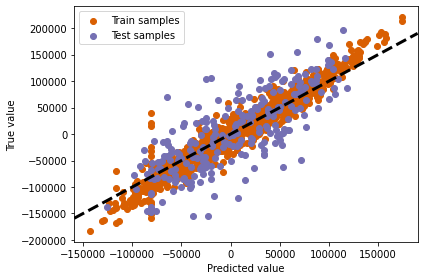

In [36]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
evaluate(model, X_train, X_test, y_train, y_test)

# ML Rollout (Phl)

Now that we have a wealth estimation model, we can apply it to the whole country. 


## Generate country-wide tiles

First, we need to split the country up into smaller areas.

That usually means generating grid tiles or hex tiles for your area of interest. In this notebook, we'll generate Bing tiles at zoom level 13 (which has the closest area to our 2km neighborhoods in training). 

[GeoWrangler provides various grid generation utilities](https://geowrangler.web.app/tutorial.grids.html) for these different scenarios.

In [37]:
# Read in the admin boundary for PHL.
# This file is a simplified version of the admin boundary to make the file size smaller and load times faster.
phl_adm = gpd.read_file(f"{DATA_DIR}/phl_adm0.geojson")

# Uncomment this line if you want to visualize it
# phl_adm.explore()

The generation can take around 1-2 minutes.

In [38]:
%%time
phl_tiles = grids.BingTileGridGenerator(13).generate_grid(phl_adm)
print(f"There are {len(phl_tiles):,} tiles.")
phl_tiles.head()

There are 16,257 tiles.
CPU times: user 27.6 s, sys: 0 ns, total: 27.6 s
Wall time: 27.6 s


,quadkey,geometry
0,1323230031332,"POLYGON ((119.44336 4.56547, 119.44336 4.60928..."
1,1323230031320,"POLYGON ((119.35547 4.60928, 119.35547 4.65308..."
2,1323230030300,"POLYGON ((119.00391 4.69688, 119.00391 4.74068..."
3,1323230030311,"POLYGON ((119.13574 4.69688, 119.13574 4.74068..."
4,1323230031201,"POLYGON ((119.22363 4.69688, 119.22363 4.74068..."


## Feature Engineering

This part is simpler, as we're just re-using the feature engineering functions we previously created. Note though that we are generating features for a bigger area, so the runtime is a little longer (in total should be within 2 minutes).

In [39]:
phl_tiles_with_features = phl_tiles.copy()

In [40]:
%%time
phl_tiles_with_features = generate_osm_features(phl_tiles_with_features, ph_osm)

CPU times: user 4.24 s, sys: 10.7 ms, total: 4.25 s
Wall time: 4.25 s


In [41]:
%%time
phl_tiles_with_features = generate_ookla_features(phl_tiles_with_features, ookla_gdf)

CPU times: user 1.93 s, sys: 20.8 ms, total: 1.95 s
Wall time: 1.95 s


In [42]:
%%time
phl_tiles_with_features = generate_ntl_features(
    phl_tiles_with_features, f"{DATA_DIR}/phl_ntl.tif"
)

CPU times: user 37.5 s, sys: 1.16 s, total: 38.6 s
Wall time: 38.7 s


## Make predictions and viz output

Finally, we are ready to apply the model and make predictions throughout the whole country. We can also visualize it on a Cholorpleth map.

In [43]:
phl_tiles_with_features["predicted_wealth_index"] = model.predict(
    phl_tiles_with_features[feature_cols]
)

In [44]:
def viz_chloropleth(gdf, target_feature="predicted_wealth_index"):

    map = folium.Map(location=[14.6091, 121.0223], width=1000, height=800, zoom_start=7)
    subset = gdf.copy()
    subset["id"] = list(range(len(subset)))

    folium.Choropleth(
        geo_data=subset,
        data=subset,
        name="Wealth Predictions",
        columns=["id", target_feature],
        key_on="feature.properties.id",
        fill_color="Spectral",
        legend_name=target_feature,
    ).add_to(map)

    return map

Visualize the output

![Predicted Wealth Index Rollout (Philippines)](images/predicted-wealth-rollout-ph.png)

In [46]:
# Uncomment the line below to visualize rollout
# viz_chloropleth(phl_tiles_with_features)